In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm

import os
import sys
sys.path.append('..')

from relations import estimate
from util import model_utils
from dsets.counterfact import CounterFactDataset
from util import nethook

In [3]:
MODEL_NAME = "EleutherAI/gpt-j-6B"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float16)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

In [4]:
ln_f = nethook.get_module(model, "transformer.ln_f")
lm_head = nethook.get_module(model, "lm_head")
encoder = nethook.get_module(model, "transformer.wte")

def get_vocab_representation(h, perform_layer_norm = True, return_top_k = 5):
    z = h.clone()
    if(perform_layer_norm == True):
        z = ln_f(z)
    logits = lm_head(z)
    token_ids = logits.topk(dim=-1, k=return_top_k).indices.squeeze().tolist()
    return [
        tokenizer.decode(t) for t in token_ids
    ]

In [52]:
test_cases = [
    ("The Space Needle", -1, "United States"),
    ("The Great Wall", -1, "China"),
    ("Niagara Falls", -2, "Canada"),
    ("Valdemarsvik", -1, "Sweden"),
    ("Kyoto University", -2, "Japan"),
    ("Hattfjelldal", -1, "Norway"),
    ("Ginza", -1, "Japan"),
    ("Sydney Hospital", -2, "Australia"),
    ("Mahalangur Himal", -1, "Nepal"),
    ("Higashikagawa", -1, "Japan"),
    ("Trento", -1, "Italy"),
    ("Taj Mahal", -1, "India"),
    ("Hagia Sophia", -1, "Turkey"),
    ("Colosseum", -1, "Italy"),
    ("Mount Everest", -1, "Nepal"),
    ("Valencia", -1, "Spain"),
    ("Lake Baikal", -1, "Russia")
]

def evaluate_against_test_cases(relation):
    for subject, subject_token_index, target in test_cases:
        objects = relation(
            subject,
            subject_token_index=subject_token_index,
            device=model.device,
            return_top_k=5,
        )
        print(f"{subject}, target: {target}   ==>   predicted: {objects}")

In [6]:
# good cases

space_needle = estimate.estimate_relation_operator(
    model, tokenizer,
    "The Space Needle",
    "{} is located in the country of",
    layer=15,
    device=model.device,
)

print(get_vocab_representation(space_needle.bias))

[' Seattle', ' Washington', ' the', ' Sweden', ' Canada']


In [7]:
evaluate_against_test_cases(space_needle)

The Space Needle, target: United States   ==>   predicted: [' Seattle', ' Washington', ' the', ' Sweden', ' America']
The Great Wall, target: China   ==>   predicted: [' China', ' Seattle', ' Beijing', ' Taiwan', ' Japan']
Niagara Falls, target: Canada   ==>   predicted: [' Niagara', ' Canada', 'Ni', ' New', ' Ontario']
Valdemarsvik, target: Sweden   ==>   predicted: [' Sweden', ' Seattle', ' Washington', ' Scandinav', ' Swedish']
Kyoto University, target: Japan   ==>   predicted: [' Kyoto', ' Japan', ' Osaka', ' Tokyo', ' Japanese']
Hattfjelldal, target: Norway   ==>   predicted: [' Norway', ' Sweden', ' Scandinav', ' Denmark', ' Washington']
Ginza, target: Japan   ==>   predicted: [' Japan', ' Tokyo', ' Seattle', ' Osaka', ' Shin']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' Sydney', ' Australian', ' Queensland', ' New']
Mahalangur Himal, target: Nepal   ==>   predicted: [' Nepal', ' Seattle', ' Washington', ' Bh', ' Switzerland']
Higashikagawa, target: Jap

## Interpreting Biases

In [18]:
calculated_relations = np.load(
    "gpt-j/P17/cached_JB/jacobian_calculations__all_sub_toks__layer_15___0_to_100.npz",
    allow_pickle=True
)["jacobians"]

In [19]:
len(calculated_relations)

100

In [32]:
calculated_relations[0]['all_weights_and_biases'][-1]['misc'].keys()

dict_keys(['Jh_norm', 'bias_norm', 'h_info', 'consider_residual'])

In [28]:
for relation_collention in calculated_relations:
    relation_operator = relation_collention['all_weights_and_biases'][-1]
    print(f"({relation_collention['subject']}, {relation_collention['request']['prompt']}, {relation_collention['request']['target_true']['str']})")
    bias = torch.tensor(relation_operator["bias"], device=model.device)
    print(get_vocab_representation(bias))

(Autonomous University of Madrid, {}, which is located in, Spain)
[' Spain', ' Madrid', ' the', ' And', ' Cast']
(Kuala Langat, {}, located in, Malaysia)
[' Malaysia', ' Pen', ' Sel', ' Sab', ' Mal']
(Wanne-Eickel Central Station, {}, located in, Germany)
[' Germany', ' Han', ' North', ' Bad', ' Sch']
(Bastille, {}, which is located in, France)
[' France', ' the', ' Belgium', ' Luxembourg', ' Brittany']
(Shablykinsky District, {} is located in the country of, Russia)
[' Russia', ' Ukraine', ' Kazakhstan', ' Belarus', ' the']
(Valdemarsvik, {}, which is located in, Sweden)
[' Sweden', ' Latvia', ' S', ' J', ' Estonia']
(Attingal, {}, which is located in, India)
[' India', ' Kerala', ' Go', ' And', ' Karn']
(Nizampatnam, {} is located in the country of, India)
[' And', ' India', ' Od', ' Tel', ' Tamil']
(Darmstadt, {} is located in the country of, Germany)
[' Germany', ' H', ' the', ' Bad', ' North']
(Adliswil, {}, which is located in, Switzerland)
[' Switzerland', ' the', ' Cant', ' Z',

In [26]:
check_with_test_cases(space_needle)

The Great Wall, target: China   ==>   predicted: [' China', ' Hong', ' Beijing', ' Chinese', ' Shen']
Niagara Falls, target: Canada   ==>   predicted: [' Canada', ' Ontario', ' Niagara', ' New', ' British']
Valdemarsvik, target: Sweden   ==>   predicted: [' Iceland', ' Denmark', ' Sweden', ' Finland', ' Norway']
Kyoto University, target: Japan   ==>   predicted: [' Japan', ' Japanese', ' Finland', ' Hawaii', ' Tokyo']
Hattfjelldal, target: Norway   ==>   predicted: [' Iceland', ' Denmark', ' Norway', ' Sweden', ' Finland']
Ginza, target: Japan   ==>   predicted: [' Japan', ' Singapore', ' China', ' Seattle', ' Hong']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' Sydney', ' Australian', ' Singapore', ' Canberra']
Mahalangur Himal, target: Nepal   ==>   predicted: [' Nepal', ' Tibet', ' Bh', ' Nep', ' China']
Higashikagawa, target: Japan   ==>   predicted: [' Japan', ' Japanese', ' Tokyo', ' Canada', ' Seattle']
Trento, target: Italy   ==>   predicted: [' Sweden'

In [22]:
space_needle_2 = estimate.estimate_relation_operator(
    model, tokenizer,
    "The Space Needle",
    "{} is located in the country of",
    layer=25,
    device=model.device,
    calculate_at_lnf= True
)

print(get_vocab_representation(space_needle_2.bias))

[' Nam', ' Beau', ' Krug', ' Macron', ' Cham']


In [27]:
check_with_test_cases(space_needle_2)

The Great Wall, target: China   ==>   predicted: [' China', ' Shen', ' Chinese', ' Qing', ' Beijing']
Niagara Falls, target: Canada   ==>   predicted: [' Niagara', 'Toronto', ' Ontario', ' Cuomo', ' Erie']
Valdemarsvik, target: Sweden   ==>   predicted: [' Nordic', ' Greenland', 'vik', ' Swedish', ' Icelandic']
Kyoto University, target: Japan   ==>   predicted: ['Japanese', ' Japanese', 'Tok', 'Japan', ' Japan']
Hattfjelldal, target: Norway   ==>   predicted: [' Nordic', ' Denmark', ' Iceland', ' Scandinavian', ' Icelandic']
Ginza, target: Japan   ==>   predicted: [' Tokyo', 'Tok', ' Japan', 'Japan', ' Japanese']
Sydney Hospital, target: Australia   ==>   predicted: [' Sydney', ' NSW', ' Australia', ' Australian', 'Australia']
Mahalangur Himal, target: Nepal   ==>   predicted: [' Himal', ' Tibetan', ' Nepal', ' Nep', ' Tibet']
Higashikagawa, target: Japan   ==>   predicted: [' Japanese', 'Japanese', ' Japan', ' Tokyo', 'Tok']
Trento, target: Italy   ==>   predicted: ['meta', ' Budapest

In [28]:
menangle = estimate.estimate_relation_operator(
    model, tokenizer,
    "Menangle Park",
    "{} is located in the country of",
    layer=25,
    device=model.device,
    subject_token_index = 1
)

get_vocab_representation(menangle.bias)

[' Australia', ' the', ' New', ' Ireland', ' South']

In [29]:
check_with_test_cases(menangle)

The Great Wall, target: China   ==>   predicted: [' China', ' India', ' Hong', ' the', ' Z']
Niagara Falls, target: Canada   ==>   predicted: [' Newfoundland', ' Ontario', ' New', ' Ireland', ' Canada']
Valdemarsvik, target: Sweden   ==>   predicted: [' Australia', ' New', ' the', ' Canada', ' Bh']
Kyoto University, target: Japan   ==>   predicted: [' India', ' Bh', ' Nepal', ' Thailand', ' Sri']
Hattfjelldal, target: Norway   ==>   predicted: [' Ireland', ' Scotland', ' the', ' Australia', ' Wales']
Ginza, target: Japan   ==>   predicted: [' India', ' Australia', ' Hong', ' Japan', ' Bh']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' Sydney', ' Queensland', ' NSW', ' New']
Mahalangur Himal, target: Nepal   ==>   predicted: [' Bh', ' Nepal', ' India', ' Sri', ' Kashmir']
Higashikagawa, target: Japan   ==>   predicted: [' Japan', ' India', ' New', ' Australia', ' the']
Trento, target: Italy   ==>   predicted: [' New', ' Australia', ' Ireland', ' the', ' France']

In [30]:
menangle_2 = estimate.estimate_relation_operator(
    model, tokenizer,
    "Menangle Park",
    "{} is located in the country of",
    layer=25,
    device=model.device,
    subject_token_index = 1,
    calculate_at_lnf= True
)

get_vocab_representation(menangle_2.bias)

[' ACT', ' NSW', ' Sydney', ' Brisbane', ' Sutherland']

In [33]:
check_with_test_cases(menangle_2)

The Great Wall, target: China   ==>   predicted: ['\x0b', '�', '\r', '龍�', '\x0f']
Niagara Falls, target: Canada   ==>   predicted: [' Niagara', '\r', '�', '�', '\x0b']
Valdemarsvik, target: Sweden   ==>   predicted: ['�', '\x0b', '�', '\r', '龍�']
Kyoto University, target: Japan   ==>   predicted: ['�', '\x0b', '\r', '龍�', '�']
Hattfjelldal, target: Norway   ==>   predicted: ['�', '\r', '�', '\x0b', '\x11']
Ginza, target: Japan   ==>   predicted: ['\x0b', '�', '\r', '�', '龍�']
Sydney Hospital, target: Australia   ==>   predicted: [' Sydney', ' NSW', '�', '\x0b', '\r']
Mahalangur Himal, target: Nepal   ==>   predicted: [' Himal', ' Nepal', ' Bh', ' Hindu', ' Kashmir']
Higashikagawa, target: Japan   ==>   predicted: ['�', '\x0b', '\r', '�', 'rawdownload']
Trento, target: Italy   ==>   predicted: ['�', '\x0b', '\r', '\x1c', '�']
Taj Mahal, target: India   ==>   predicted: ['�', '\r', '\x0b', '\x08', '龍�']


In [ ]:
(space_needle.bias - menangle.bias).norm()

tensor(269.9868, device='cuda:0')

## Difference with USUAL calculation

In [11]:
final_layer = f"transformer.h.{model.config.n_layer-1}"

In [12]:
prompt = "The Space Needle is located in the city of"

tokenized = tokenizer(prompt, padding=True, return_tensors="pt").to(
    next(model.parameters()).device
)

with nethook.TraceDict(
    model, [final_layer, "transformer.ln_f"]
) as traces:  
    output = model(**tokenized)

In [13]:
get_vocab_representation(traces[final_layer].output[0][0][-1])

[' Seattle', ' Seat', ' the', ' Portland', ' Space']

In [14]:
get_vocab_representation(traces["transformer.ln_f"].output[0][-1], perform_layer_norm= False)

[' Seattle', ' Seat', ' the', ' Portland', ' Space']

In [15]:
logits = output.logits[:, -1, :]
token_ids = logits.topk(dim=-1, k=5).indices.squeeze().tolist()
[tokenizer.decode(t) for t in token_ids]

[' Seattle', ' Seat', ' the', ' Portland', ' Space']

In [17]:
for subject, subject_token_index, target in test_cases:
    objects, z_est = space_needle(
        subject,
        subject_token_index=subject_token_index,
        device=model.device,
        return_top_k=5,
    )
    print(f"{subject}, target: {target}")

    prompt = "{} is located in the country of".format(subject)
    tokenized = tokenizer(prompt, padding=True, return_tensors="pt").to(next(model.parameters()).device)
    with nethook.TraceDict(
        model, [final_layer, "transformer.ln_f"]
    ) as traces:  
        output = model(**tokenized)
    z = traces[final_layer].output[0][0][-1]

    print("z_ = ", get_vocab_representation(z))
    print("z_est = ", get_vocab_representation(z_est))
    print("Distance => ", torch.dist(z, z_est).item())
    print()
    

The Great Wall, target: China
z_ =  [' China', ' G', ' Shan', ' the', ' Great']
z_est =  [' China', ' Seattle', ' Beijing', ' Taiwan', ' Japan']
Distance =>  169.125

Niagara Falls, target: Canada
z_ =  [' Canada', ' Ontario', ' New', ' the', ' Niagara']
z_est =  [' Niagara', ' Canada', 'Ni', ' New', ' Ontario']
Distance =>  180.25

Valdemarsvik, target: Sweden
z_ =  [' Sweden', ' S', ' J', ' Latvia', ' V']
z_est =  [' Sweden', ' Seattle', ' Washington', ' Scandinav', ' Swedish']
Distance =>  179.25

Kyoto University, target: Japan
z_ =  [' Japan', ' Kyoto', ' Ky', ' the', ' H']
z_est =  [' Kyoto', ' Japan', ' Osaka', ' Tokyo', ' Japanese']
Distance =>  163.25

Hattfjelldal, target: Norway
z_ =  [' Norway', ' Nord', ' S', ' Tr', ' Finn']
z_est =  [' Norway', ' Sweden', ' Scandinav', ' Denmark', ' Washington']
Distance =>  189.75

Ginza, target: Japan
z_ =  [' Japan', ' Tokyo', ' the', ' Ch', ' Shin']
z_est =  [' Japan', ' Tokyo', ' Seattle', ' Osaka', ' Shin']
Distance =>  150.75

Sydn

## Which contributes the most? $Jh$ or $bias$?

In [46]:
os.listdir("gpt-j/P17/cached_JB/")

['jacobian_calculations__all_sub_toks__layer_15___200_to_300.npz',
 'jacobian_calculations__all_sub_toks__layer_15___300_to_400.npz',
 'jacobian_calculations__all_sub_toks__layer_15___400_to_404.npz',
 'jacobian_calculations__all_sub_toks__layer_15___100_to_200.npz',
 'jacobian_calculations__all_sub_toks__layer_15___0_to_100.npz']

In [50]:
jh_collection = []
bias_collection = []
rank_collection = []

path = "gpt-j/P17/cached_JB/"
cached_jb_files = os.listdir(path)

for jb_file in cached_jb_files:
    print("loading --> ", jb_file)
    calculated_relations = np.load(f"{path}{jb_file}", allow_pickle=True)["jacobians"]
    for relation_collention in tqdm(calculated_relations):
        relation_operator = relation_collention['all_weights_and_biases'][-1]
        jh_collection.append(relation_operator['misc']['Jh_norm'])
        bias_collection.append(relation_operator['misc']['bias_norm'])
        J = torch.tensor(relation_operator["weight"], device=model.device, dtype=torch.float32)
        rank_collection.append(torch.linalg.matrix_rank(J).item())

loading -->  jacobian_calculations__all_sub_toks__layer_15___200_to_300.npz


100%|██████████| 100/100 [03:39<00:00,  2.20s/it]


loading -->  jacobian_calculations__all_sub_toks__layer_15___300_to_400.npz


100%|██████████| 100/100 [03:40<00:00,  2.20s/it]


loading -->  jacobian_calculations__all_sub_toks__layer_15___400_to_404.npz


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


loading -->  jacobian_calculations__all_sub_toks__layer_15___100_to_200.npz


100%|██████████| 100/100 [03:41<00:00,  2.21s/it]


loading -->  jacobian_calculations__all_sub_toks__layer_15___0_to_100.npz


100%|██████████| 100/100 [03:40<00:00,  2.21s/it]


In [52]:
jh_collection = np.array(jh_collection)
bias_collection = np.array(bias_collection)
rank_collection = np.array(rank_collection)

In [53]:
f"{jh_collection.mean()} +/- {jh_collection.std()}"

'12.675278465346535 +/- 8.163360430617857'

In [54]:
f"{bias_collection.mean()} +/- {bias_collection.std()}"

'254.11355198019803 +/- 23.25887094834684'

In [55]:
f"{rank_collection.mean()} +/- {rank_collection.std()}"

'3788.05198019802 +/- 115.54177064337186'

## Good case vs Bad cases

In [56]:
# (s, o, h_idx)
relation_format = '{} is located in the country of'
good_cases = [
    ('Haut Atlas', 'Morocco', 2),
    ('Pamukkale', 'Turkey', 4),
    ('Fort Madalena', 'Malta', 3),
    ('Umarex', 'Germany', 2),
    ('Qatar Ladies Open', 'Qatar', 2),
    ('Sydney Peace Prize', 'Australia', 4),
    ('Alte Nationalgalerie', 'Germany', 4),
]

In [58]:
good_relations = []
for subject, object, h_idx in tqdm(good_cases):
    relation = estimate.estimate_relation_operator(
        model, tokenizer,
        subject, relation_format,
        subject_token_index= h_idx,
        layer = 15,
        device= model.device
    )
    good_relations.append(relation)

100%|██████████| 7/7 [00:29<00:00,  4.25s/it]


In [61]:
weights = [r.weight for r in good_relations]
bias = [r.bias for r in good_relations]

In [66]:
for one in range(len(weights)):
    w1 = weights[one]
    dist = [round(torch.dist(w1, w2).item(),3) for w2 in weights]
    print(round(w1.norm().item(), 3), dist)

19.188 [0.0, 38.375, 21.688, 18.078, 23.047, 21.859, 26.297]
39.75 [38.375, 0.0, 36.188, 38.625, 38.406, 40.906, 38.406]
20.594 [21.688, 36.188, 0.0, 21.422, 23.797, 24.375, 26.688]
15.312 [18.078, 38.625, 21.422, 0.0, 22.859, 19.344, 24.812]
23.0 [23.047, 38.406, 23.797, 22.859, 0.0, 25.266, 27.953]
18.828 [21.859, 40.906, 24.375, 19.344, 25.266, 0.0, 27.016]
26.5 [26.297, 38.406, 26.688, 24.812, 27.953, 27.016, 0.0]


In [67]:
for one in range(len(bias)):
    w1 = bias[one]
    dist = [round(torch.dist(w1, w2).item(),3) for w2 in bias]
    print(round(w1.norm().item(), 3), dist)

269.75 [0.0, 178.0, 92.938, 92.312, 107.188, 131.125, 137.125]
230.5 [178.0, 0.0, 174.125, 173.5, 186.375, 188.25, 172.75]
253.25 [92.938, 174.125, 0.0, 102.312, 115.125, 131.375, 139.5]
247.25 [92.312, 173.5, 102.312, 0.0, 107.188, 124.312, 122.062]
274.25 [107.188, 186.375, 115.125, 107.188, 0.0, 134.625, 150.25]
246.0 [131.125, 188.25, 131.375, 124.312, 134.625, 0.0, 137.125]
216.75 [137.125, 172.75, 139.5, 122.062, 150.25, 137.125, 0.0]


In [83]:
import random
calculated_relations = np.load(
    "gpt-j/P17/cached_JB/jacobian_calculations__all_sub_toks__layer_15___0_to_100.npz",
    allow_pickle=True
)["jacobians"]

random_indices = random.choices(range(0, len(calculated_relations)), k = 7)
print(random_indices)

weights = []
bias = []

for idx in tqdm(random_indices):
    relation_collention = calculated_relations[idx]
    relation_operator = relation_collention['all_weights_and_biases'][-1]
    weights.append(torch.tensor(relation_operator["weight"], device=model.device, dtype=torch.float32))
    bias.append(torch.tensor(relation_operator["bias"], device=model.device, dtype=torch.float32))

[3, 33, 5, 80, 64, 69, 39]


100%|██████████| 7/7 [00:00<00:00, 93.92it/s]


In [84]:
for one in range(len(weights)):
    w1 = weights[one]
    dist = [round(torch.dist(w1, w2).item(),3) for w2 in weights]
    print(round(w1.norm().item(), 3), dist)

17.549 [0.0, 17.949, 19.386, 27.599, 17.965, 16.597, 23.482]
9.679 [17.949, 0.0, 17.015, 27.033, 10.177, 10.039, 19.596]
16.475 [19.386, 17.015, 0.0, 28.162, 17.053, 15.313, 22.612]
27.394 [27.599, 27.033, 28.162, 0.0, 27.206, 26.912, 31.171]
8.184 [17.965, 10.177, 17.053, 27.206, 0.0, 8.961, 18.904]
5.596 [16.597, 10.039, 15.313, 26.912, 8.961, 0.0, 18.207]
18.04 [23.482, 19.596, 22.612, 31.171, 18.904, 18.207, 0.0]


In [85]:
for one in range(len(bias)):
    w1 = bias[one]
    dist = [round(torch.dist(w1, w2).item(),3) for w2 in bias]
    print(round(w1.norm().item(), 3), dist)

280.816 [0.0, 161.95, 138.882, 134.235, 178.476, 129.226, 172.651]
223.301 [161.95, 0.0, 163.701, 160.271, 165.099, 167.165, 176.24]
259.589 [138.882, 163.701, 0.0, 160.631, 180.087, 109.962, 180.799]
273.735 [134.235, 160.271, 160.631, 0.0, 173.806, 157.031, 169.659]
237.356 [178.476, 165.099, 180.087, 173.806, 0.0, 181.295, 173.081]
250.456 [129.226, 167.165, 109.962, 157.031, 181.295, 0.0, 174.918]
240.872 [172.651, 176.24, 180.799, 169.659, 173.081, 174.918, 0.0]


## Testing $J$ as *identity*

### Usual computation of the jacobian

In [7]:
import gc
del space_needle
gc.collect()

0

In [8]:
####################################################
# sos = (
#     ("The Great Wall", -1, "China"),
#     ("Niagara Falls", -2, "Canada"),
#     ("Ginza", -1, "Japan"),
# )

sos = (
    ("Haut Atlas", -1, "Morocco"),
    ("Pamukkale", -1, "Turkey"),
    ("Fort Madalena", -1, "Malta"),
    # ("Umarex", -1, "Germany"),
    ("Alte Nationalgalerie", -1, "Germany")
)

r = "{} is located in the country of"
####################################################

In [9]:
jbs = []
for s, s_idx, o in tqdm(sos):
    others = set(sos) - {(s, s_idx, o)}
    prompt = ""
    prompt += "\n".join(r.format(s_other) + f" {o_other}." for s_other, idx_other, o_other in others) + "\n"
    prompt += r
    print("subject: ", s)
    print(prompt)

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    jb = estimate.estimate_relation_operator(
        model, tokenizer,
        s, prompt,
        subject_token_index= s_idx,
        layer = 15,
        device = model.device,
    )
    print(jb.weight.norm(), jb.bias.norm())
    print()
    jbs.append(jb)

relation = estimate.RelationOperator(
    weight=torch.stack([jb.weight for jb in jbs]).mean(dim=0),
    bias=torch.stack([jb.bias for jb in jbs]).mean(dim=0),
    model=model,
    tokenizer=tokenizer,
    layer= 15 ,
    relation=r,
)

  0%|          | 0/4 [00:00<?, ?it/s]

subject:  Haut Atlas
Pamukkale is located in the country of Turkey.
Fort Madalena is located in the country of Malta.
Alte Nationalgalerie is located in the country of Germany.
{} is located in the country of
tensor(28.6719, device='cuda:0', dtype=torch.float16) tensor(281.7500, device='cuda:0', dtype=torch.float16)

subject:  Pamukkale
Haut Atlas is located in the country of Morocco.
Fort Madalena is located in the country of Malta.
Alte Nationalgalerie is located in the country of Germany.
{} is located in the country of
tensor(36.9688, device='cuda:0', dtype=torch.float16) tensor(222.3750, device='cuda:0', dtype=torch.float16)

subject:  Fort Madalena
Pamukkale is located in the country of Turkey.
Haut Atlas is located in the country of Morocco.
Alte Nationalgalerie is located in the country of Germany.
{} is located in the country of
tensor(25.0781, device='cuda:0', dtype=torch.float16) tensor(272.7500, device='cuda:0', dtype=torch.float16)

subject:  Alte Nationalgalerie
Pamukkale

In [10]:
evaluate_against_test_cases(relation)

The Space Needle, target: United States   ==>   predicted: [' Sweden', ' Turkey', ' Switzerland', ' Belgium', ' Seattle']
The Great Wall, target: China   ==>   predicted: [' China', ' Taiwan', ' Germany', ' Turkey', ' Hong']
Niagara Falls, target: Canada   ==>   predicted: [' Canada', ' Niagara', ' Austria', ' Italy', ' Switzerland']
Valdemarsvik, target: Sweden   ==>   predicted: [' Sweden', ' Iceland', ' Finland', ' Norway', ' Denmark']
Kyoto University, target: Japan   ==>   predicted: [' Japan', ' Kyoto', ' Thailand', ' Taiwan', ' Japanese']
Hattfjelldal, target: Norway   ==>   predicted: [' Norway', ' Denmark', ' Sweden', ' Iceland', ' Switzerland']
Ginza, target: Japan   ==>   predicted: [' Japan', ' Turkey', ' China', ' Taiwan', ' Tokyo']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' Sydney', ' Australian', ' NSW', 'Australia']
Mahalangur Himal, target: Nepal   ==>   predicted: [' Nepal', ' India', ' Switzerland', ' Bh', ' Pakistan']
Higashikagawa, targe

In [11]:
test_subject = "Merlion Park"
# test_subject = "Cape Sounion"
# test_subject = "Zagori"
# test_subject = "Cologne Cathedral"
# test_subject = "Buda Castle"


# print("space_needle ==> ", space_needle(test_subject, device = model.device, return_top_k = 10))
print("Averaged ==> ", relation(test_subject, device = model.device, return_top_k = 10))

generated_text, gen_dict = model_utils.generate_fast(
    model, tokenizer, prompts= r.format(test_subject), 
    argmax_greedy=True, get_answer_tokens=True,
    max_new_tokens=5, top_k= 10
)

print(generated_text)
gen_dict['answer']

Averaged ==>  [' Malta', ' Turkey', ' Malaysia', ' Luxembourg', ' Singapore', ' Switzerland', ' Australia', ' Hong', ' South', ' Belgium']
['Merlion Park is located in the country of Singapore, and is a']


[{'top_token': ' Singapore',
  'candidates': [{'token': ' Singapore', 'token_id': 12551, 'p': 0.2999},
   {'token': ' Malaysia', 'token_id': 15336, 'p': 0.1231},
   {'token': ' Brune', 'token_id': 46070, 'p': 0.102},
   {'token': ' Pen', 'token_id': 7507, 'p': 0.0654},
   {'token': ' Sab', 'token_id': 9910, 'p': 0.0517},
   {'token': ' the', 'token_id': 262, 'p': 0.0187},
   {'token': ' Cambodia', 'token_id': 31057, 'p': 0.0145},
   {'token': ' Joh', 'token_id': 16053, 'p': 0.0121},
   {'token': ' Bel', 'token_id': 3944, 'p': 0.0114},
   {'token': ' Per', 'token_id': 2448, 'p': 0.0113}]}]

### Replace J as identity

In [13]:
jbs = []
for s, s_idx, o in tqdm(sos):
    others = set(sos) - {(s, s_idx, o)}
    prompt = ""
    prompt += "\n".join(r.format(s_other) + f" {o_other}." for s_other, idx_other, o_other in others) + "\n"
    prompt += r
    print(prompt)

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    jb = estimate.estimate_relation_operator(
        model, tokenizer,
        s, prompt,
        subject_token_index= s_idx,
        layer = 15,
        device = model.device,
        test_identity = True
    )
    print()
    jbs.append(jb)

relation_id = estimate.RelationOperator(
    weight=torch.stack([jb.weight for jb in jbs]).mean(dim=0),
    bias=torch.stack([jb.bias for jb in jbs]).mean(dim=0),
    model=model,
    tokenizer=tokenizer,
    layer= 15 ,
    relation=r,
)

  0%|          | 0/4 [00:00<?, ?it/s]

Pamukkale is located in the country of Turkey.
Fort Madalena is located in the country of Malta.
Alte Nationalgalerie is located in the country of Germany.
{} is located in the country of

Haut Atlas is located in the country of Morocco.
Fort Madalena is located in the country of Malta.
Alte Nationalgalerie is located in the country of Germany.
{} is located in the country of

Pamukkale is located in the country of Turkey.
Haut Atlas is located in the country of Morocco.
Alte Nationalgalerie is located in the country of Germany.
{} is located in the country of

Pamukkale is located in the country of Turkey.
Haut Atlas is located in the country of Morocco.
Fort Madalena is located in the country of Malta.
{} is located in the country of



In [14]:
get_vocab_representation(relation_id.bias)

[' Germany', ' Turkey', ' France', ' Greece', '\n']

In [29]:
evaluate_against_test_cases(relation_id)

The Space Needle, target: United States   ==>   predicted: ['\n', ' the', '...', ' Canada', ' Japan']
The Great Wall, target: China   ==>   predicted: [' China', '\n', ' the', ' Japan', ' Canada']
Niagara Falls, target: Canada   ==>   predicted: [' Canada', '\n', ' United', ' the', ' Japan']
Valdemarsvik, target: Sweden   ==>   predicted: ['\n', ' the', ' Canada', ' United', ' ']
Kyoto University, target: Japan   ==>   predicted: [' Japan', '\n', ' United', ' Canada', ' the']
Hattfjelldal, target: Norway   ==>   predicted: ['\n', ' the', ' United', ' ', ' Canada']
Ginza, target: Japan   ==>   predicted: [' Japan', '\n', ' the', ' United', ' China']
Sydney Hospital, target: Australia   ==>   predicted: [' Australia', ' Canada', ' United', '\n', ' the']
Mahalangur Himal, target: Nepal   ==>   predicted: ['\n', ' the', '...', ' ', ' Canada']
Higashikagawa, target: Japan   ==>   predicted: ['\n', ' Japan', ' Canada', ' the', ' ']
Trento, target: Italy   ==>   predicted: ['\n', ' the', ' Un

In [91]:
encoder.weight.shape

torch.Size([50400, 4096])

In [143]:
import baukit


def check_distance_with_bias(relation_operator, test_subjects):
    print(get_vocab_representation(relation.bias))
    for test_subject in test_subjects:
        print(test_subject)
        prompt = relation_operator.relation.format(test_subject)
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        z_layername = f"transformer.h.{model.config.n_layer - 1}"
        with baukit.TraceDict(model, [z_layername]) as traces:
            outputs = model(**inputs)
        repr = traces[z_layername].output[0][0][-1][None]
        print(torch.dist(relation.bias, repr).item(), get_vocab_representation(repr))
        print()

In [144]:
successes = [
    "Taj Mahal", "Hagia Sophia", "Colosseum",
    "Mount Everest", "Valencia", "Lake Baikal",
]

check_distance_with_bias(relation, successes)

[' Turkey', ' Germany', ' France', ' Portugal', ' Italy']
Taj Mahal
153.5 [' India', ' Pakistan', ' Uttar', ' the', ' Bangladesh']

Hagia Sophia
135.625 [' Turkey', ' Greece', ' Istanbul', ' the', ' modern']

Colosseum
125.8125 [' Italy', ' the', ' San', ' Romania', ' Rome']

Mount Everest
169.375 [' Nepal', ' China', ' the', ' Tibet', ' Bh']

Valencia
134.25 [' Spain', ' Valencia', ' And', ' the', ' Venezuela']

Lake Baikal
171.375 [' Russia', ' Siberia', ' Mongolia', ' the', ' Ir']



In [146]:
failures = ["Merlion Park", "Cape Sounion", "Zagori", "Cologne Cathedral", "Buda Castle"]

check_distance_with_bias(relation, failures)

[' Turkey', ' Germany', ' France', ' Portugal', ' Italy']
Merlion Park
143.875 [' Singapore', ' Malaysia', ' Brune', ' Pen', ' Sab']

Cape Sounion
152.375 [' Greece', ' Att', ' the', ' Cre', ' Pel']

Zagori
152.75 [' Georgia', ' Macedonia', ' Bulgaria', ' Greece', ' the']

Cologne Cathedral
135.25 [' Germany', ' North', ' Cologne', ' Bad', ' H']

Buda Castle
134.5 [' Hungary', ' Romania', ' the', ' Slovakia', ' Trans']



### Scan through all the `GPT-J` correct predictions

In [148]:
with open("gpt-j/P17/correct_prediction_P17.json") as f:
    correct_predictions = json.load(f)
len(correct_predictions)

404

In [152]:
correct_predictions[0]['subject']

'Autonomous University of Madrid'

In [153]:
correct_predictions[2]

{'prompt': '{}, located in',
 'relation_id': 'P17',
 'target_new': {'str': 'Switzerland', 'id': 'Q39'},
 'target_true': {'str': 'Germany', 'id': 'Q183'},
 'subject': 'Wanne-Eickel Central Station'}

In [173]:
z_layername = f"transformer.h.{model.config.n_layer - 1}"
precision_at = 3
successes_dist = []
failures_dist = []

for c in tqdm(correct_predictions):
    test_subject = c['subject']
    # print(f"s = {test_subject}, o = {c['target_true']['str']}")
    prompt = relation.relation.format(test_subject)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with baukit.TraceDict(model, [z_layername]) as traces:
        outputs = model(**inputs)
    repr = traces[z_layername].output[0][0][-1][None]
    
    dist = torch.dist(relation.bias, repr).item()
    model_predicted = get_vocab_representation(repr)
    # print(dist)
    # print("Usual Computation: ", model_predicted)
    jb_predicted = relation(
        test_subject, subject_token_index=-1, device=model.device,
    )
    # print("Jacobian-bias: ", jb_predicted)
    # print()
    if(model_predicted[0] in jb_predicted[0:precision_at]):
        successes_dist.append(dist)
    else:
        failures_dist.append(dist)

  0%|          | 0/404 [00:00<?, ?it/s]

In [174]:
successes_dist = np.array(successes_dist)
failures_dist = np.array(failures_dist)

successes_dist.shape, failures_dist.shape

((310,), (94,))

In [175]:
successes_dist.mean()

147.34012096774194

In [176]:
failures_dist.mean()

146.6130319148936

## Jacobian Heatmaps

In [4]:
cut_off = 50 # minimum number of correct predictions

###########################################################################
relation_dct = {
    'P17'   : {'relation': '{} is located in the country of', 'correct_predict': None, 'cached_JB': None},
    'P641'  : {'relation': '{} plays the sport of', 'correct_predict': None, 'cached_JB': None},
    'P103'  : {'relation': 'The mother tongue of {} is', 'correct_predict': None, 'cached_JB': None},
    'P176'  : {'relation': '{} is produced by', 'correct_predict': None, 'cached_JB': None},
    'P140'  : {'relation': 'The official religion of {} is', 'correct_predict': None, 'cached_JB': None},
    'P1303' : {'relation': '{} plays the instrument', 'correct_predict': None, 'cached_JB': None},
    'P190'  : {'relation': 'What is the twin city of {}? It is', 'correct_predict': None, 'cached_JB': None},
    'P740'  : {'relation': '{} was founded in', 'correct_predict': None, 'cached_JB': None},
    'P178'  : {'relation': '{} was developed by', 'correct_predict': None, 'cached_JB': None},
    'P495'  : {'relation': '{}, that originated in the country of', 'correct_predict': None, 'cached_JB': None},
    'P127'  : {'relation': '{} is owned by', 'correct_predict': None, 'cached_JB': None},
    'P413'  : {'relation': '{} plays in the position of', 'correct_predict': None, 'cached_JB': None},
    'P39'   : {'relation': '{}, who holds the position of', 'correct_predict': None, 'cached_JB': None},
    'P159'  : {'relation': 'The headquarter of {} is located in', 'correct_predict': None, 'cached_JB': None},
    'P20'   : {'relation': '{} died in the city of', 'correct_predict': None, 'cached_JB': None},
    'P136'  : {'relation': 'What does {} play? They play', 'correct_predict': None, 'cached_JB': None},
    'P106'  : {'relation': 'The profession of {} is', 'correct_predict': None, 'cached_JB': None},
    'P30'   : {'relation': '{} is located in the continent of', 'correct_predict': None, 'cached_JB': None},
    'P937'  : {'relation': '{} worked in the city of', 'correct_predict': None, 'cached_JB': None},
    'P449'  : {'relation': '{} was released on', 'correct_predict': None, 'cached_JB': None},
    'P27'   : {'relation': '{} is a citizen of', 'correct_predict': None, 'cached_JB': None},
    'P101'  : {'relation': '{} works in the field of', 'correct_predict': None, 'cached_JB': None},
    'P19'   : {'relation': '{} was born in', 'correct_predict': None, 'cached_JB': None},
    'P37'   : {'relation': 'In {}, an official language is', 'correct_predict': None, 'cached_JB': None},
    'P138'  : {'relation': '{}, named after', 'correct_predict': None, 'cached_JB': None},
    'P131'  : {'relation': '{} is located in', 'correct_predict': None, 'cached_JB': None},
    'P407'  : {'relation': '{} was written in', 'correct_predict': None, 'cached_JB': None},
    'P108'  : {'relation': '{}, who is employed by', 'correct_predict': None, 'cached_JB': None},
    'P36'   : {'relation': 'The capital of {} is', 'correct_predict': None, 'cached_JB': None},
}
###########################################################################

root_path = "gpt-j"

pop_track = []
for relation in relation_dct:
    path = f"{root_path}/{relation}"
    with open(f"{path}/correct_prediction_{relation}.json") as f:
        correct_predictions = json.load(f)
    if(len(correct_predictions) < cut_off):
    # if "performance" not in os.listdir(path):
        print("skipped ", relation)
        pop_track.append(relation)
    
for r in pop_track:
    relation_dct.pop(r)

skipped  P1303
skipped  P190
skipped  P740
skipped  P413
skipped  P39
skipped  P136
skipped  P449
skipped  P138
skipped  P131
skipped  P407
skipped  P108


In [5]:
len(relation_dct)

18

In [35]:
sqr = torch.rand(3,3)
print(sqr)

a = np.zeros((3, 3))
np.fill_diagonal(a, sqr.diagonal())
print(a)

tensor([[0.9322, 0.7614, 0.7227],
        [0.1577, 0.7570, 0.2324],
        [0.0835, 0.0429, 0.6653]])
[[0.93223315 0.         0.        ]
 [0.         0.75702256 0.        ]
 [0.         0.         0.66533583]]


In [48]:
torch.tensor([1,2,-3,1], dtype=float).abs()

tensor([1., 2., 3., 1.], dtype=torch.float64)

In [60]:
def calculate_identity_significance(weight):
    dim = weight.shape[0]
    corner_values = weight.diagonal()
    only_corner = np.zeros(weight.shape) 
    np.fill_diagonal(only_corner, corner_values)
    other_values = weight - torch.tensor(only_corner).to(weight.dtype).to(weight.device)
    # print(other_contribution, other_contribution/(weight.shape[0]*weight.shape[1] - weight.shape[1]))
    corner_contribution = corner_values.abs().sum()/corner_values.shape[0]
    other_contribution = other_values.abs().sum()/(weight.shape[0]*weight.shape[1] - weight.shape[1])
    significance = corner_contribution/other_contribution
    return significance
    
calculate_identity_significance(weight)

tensor(1.0794)

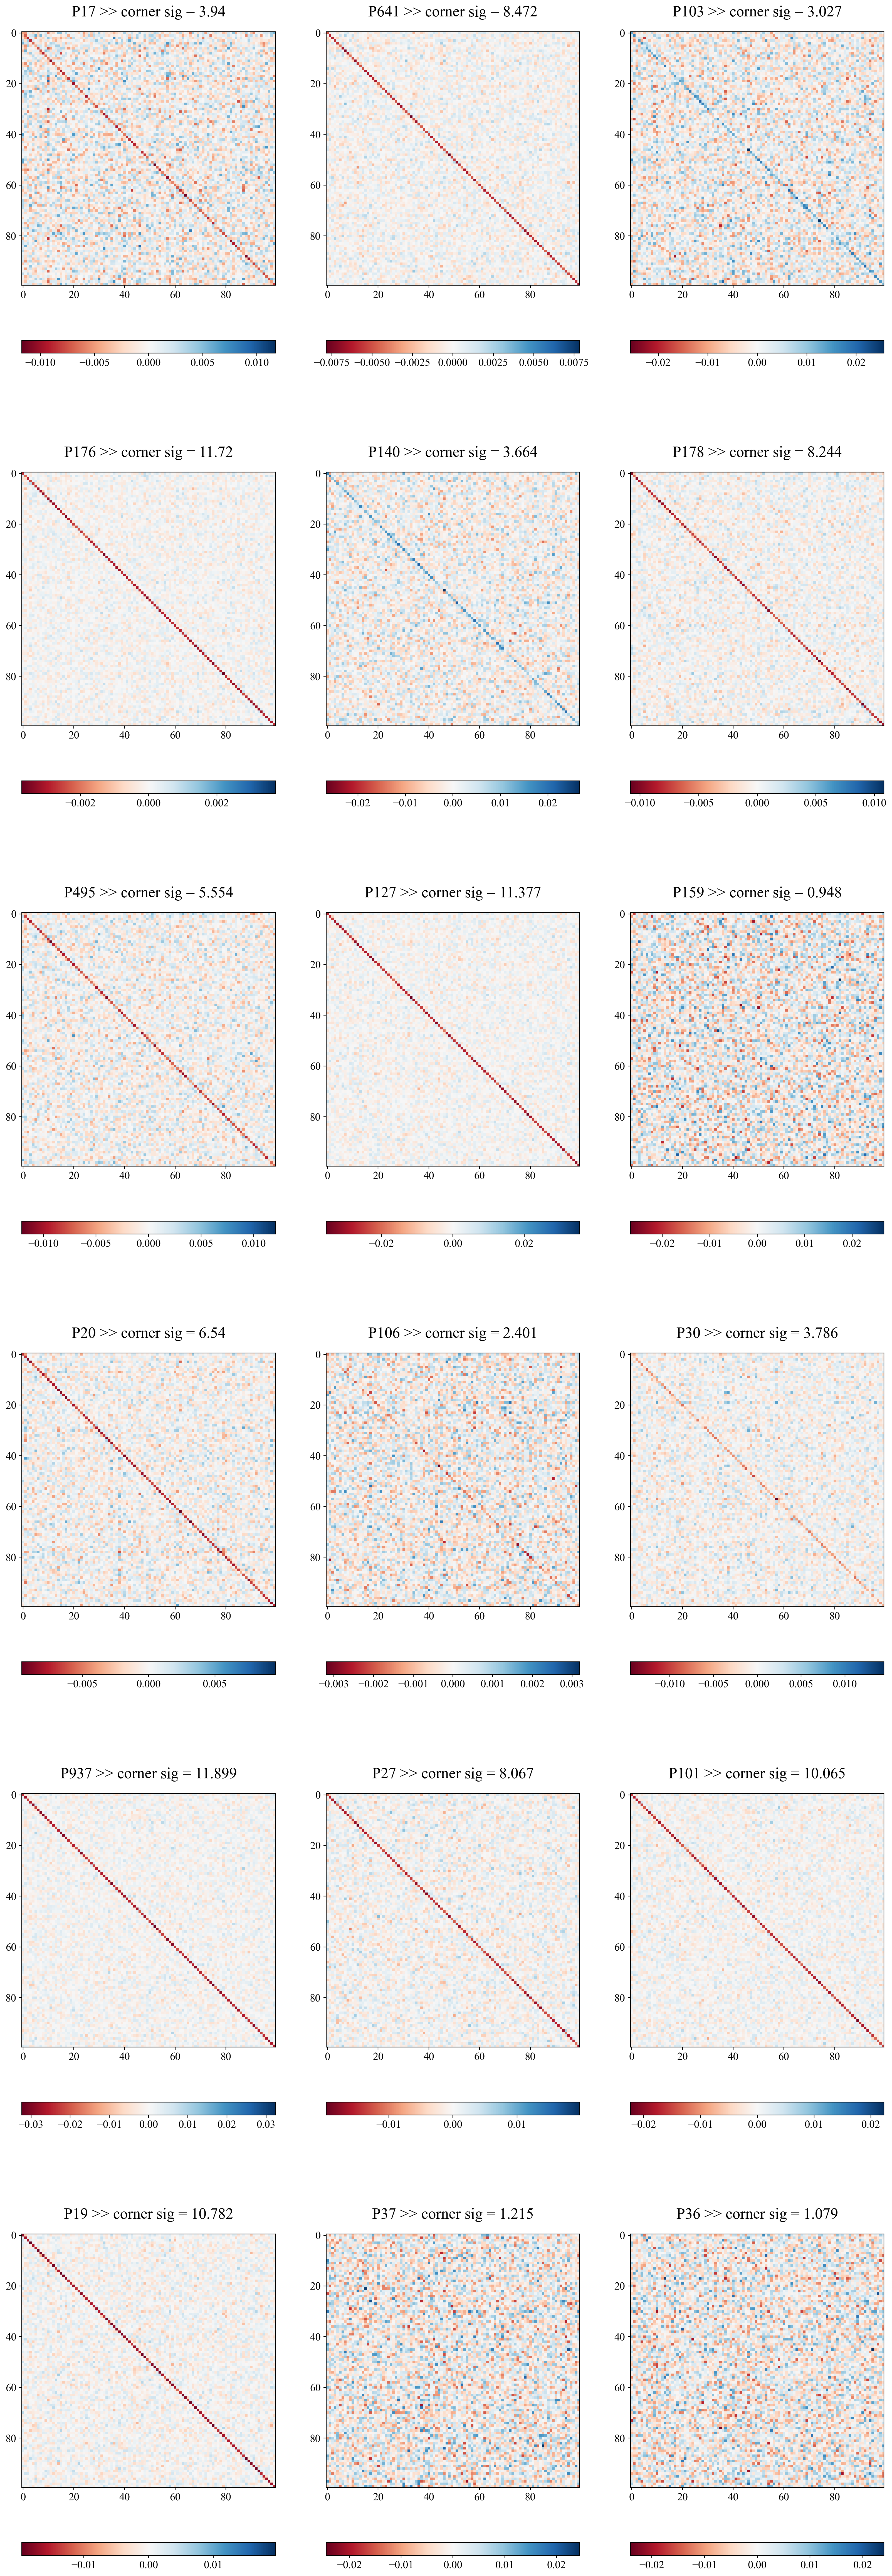

In [62]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,60)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.titlepad'] = 20 

SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=MEDIUM_SIZE)  # fontsize of the figure title

num_column = 3
fig, ax = plt.subplots(ncols=num_column, nrows=len(relation_dct)//num_column)
cur_row, cur_col = 0, 0

for relation_id in relation_dct:
    jb = np.load(f"gpt-j/jacobians_averaged/{relation_id}.npz", allow_pickle= True)
    weight = torch.tensor(jb["JB"][0]["weight"]).to(torch.float32)
    weight = torch.stack([w[:100] for w in weight[:100]])
    # bias = jb["JB"][0]["bias"]
    limit = max(abs(weight.min().item()), abs(weight.max().item())) 
    identity = torch.eye(weight.shape[0]).to(weight.dtype)
    # ax[cur_row, cur_col].set_title(f"{relation_id} >> L2 norm = {np.round(weight.norm().item(), 3)}, dist(I, J) = {np.round(torch.dist(weight, identity).item(), 3)}")
    corner_sig = calculate_identity_significance(weight=weight)
    ax[cur_row, cur_col].set_title(f"{relation_id} >> corner sig = {np.round(corner_sig.item(), 3)}")
    im = ax[cur_row, cur_col].imshow(weight, cmap='RdBu', interpolation='nearest', vmin = -limit, vmax = limit)
    plt.colorbar(im, ax = ax[cur_row, cur_col], orientation='horizontal')

    cur_col += 1
    if(cur_col == num_column):
        cur_col = 0
        cur_row += 1


In [19]:
identity = np.eye(weight.shape[0])
np.linalg.norm(identity - weight), np.linalg.norm(weight), torch.

(65.13352861436829, 9.46)

In [33]:
weight.max(), weight.min(), weight.mean()

(0.1553, -0.10376, -0.0)

In [29]:
torch.dist(torch.tensor(identity), torch.tensor(weight))

tensor(65.1335, dtype=torch.float64)

In [26]:
arr = np.array([1,2,3,4,5])

torch.tensor(arr).to(torch.float64).norm(), np.linalg.norm(arr)

(tensor(7.4162, dtype=torch.float64), 7.416198487095663)

In [28]:
torch.tensor(weight).to(torch.float32).norm(), np.linalg.norm(weight)

(tensor(9.6239), 9.46)

In [20]:
relation_to_jacobians["P17"].norm()

tensor(2.5527, dtype=torch.float16)

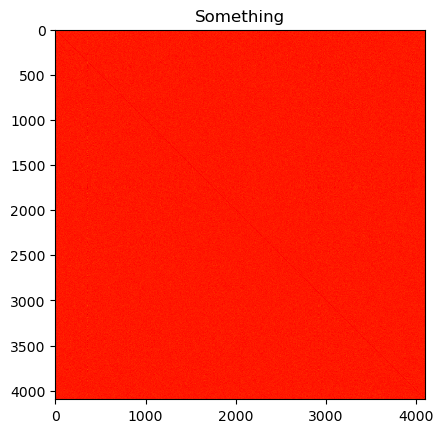

In [10]:


for relation_id in relation_dct:
    weight = relation_to_jacobians[relation_id]
    plt.title("")
    break